In [68]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def func(x):
  return 3*x**2 - 4*x

In [70]:
func(4.0)

32.0

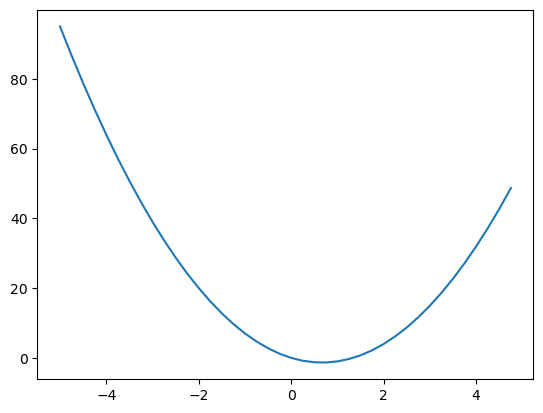

In [71]:
xs = np.arange(-5, 5, 0.25)
ys = func(xs)
plt.plot(xs, ys)
plt.show()

In [72]:
h = 0.0001
x = 2/3
(func(x + h) - func(x))/h

0.00030000000039720476

- Deriviate is telling me if i increase x just a little bit, then how does the function respond?
- Is it going up or down at that slope? (rise over run)
- Slope is the steepness of a point.
- Other way of thinking is: How much does y change if I change x a little bit?

In [73]:
a = 2.0
b = -3.0
c = 10

d = a*b + c
print(d)

4.0


In [74]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


- increasing c by h results in h/h -> 1
- increasing a by h results in a negative slope, because a is increased and multiplied by negative
- increasing b by h results in a positive slope, because b is increased(less of a negative number)

This all tells us how much each number contirbutes to the outcome!

In [93]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # Init 0, means zero effect -> It dosent effect the output
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [76]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

- Backward pass will be the deriviate of L in respect to each Value object.

In [77]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

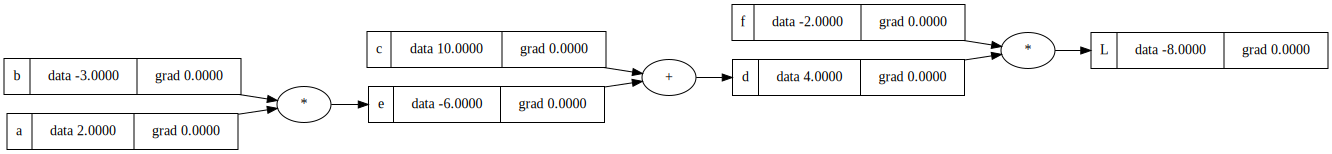

In [78]:
draw_dot(L)


In [79]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

- Calculating the gradient for each Value
"How much does L change in terms of: a,b,c,d,e,f"

- L = d * f
--> dL/dd = f

Proof: 
1. (f(x + h) - f(x)) / h
2. ((d+h)*f - d*f) / h
3. (df + fh - df) /h
4. fh / h
5. f

- Chainrule
dL/dc  How is L effected by c? But we have d in the middle of it?
dd/dc How is d effected by c?

1. ((c+h) + e - c + e) / h
2. h/h 
3. 1

WANT: 
dL/dc

KNOW:
dl/dd -> -2.0
dd/dc -> 1.0

-2.0 * 1.0 -> -2.0


In [80]:
# Increase the leaf nodes in respect to the grads
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

# rerun the forward pass
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
L

Value(data=-7.286496)

In [81]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


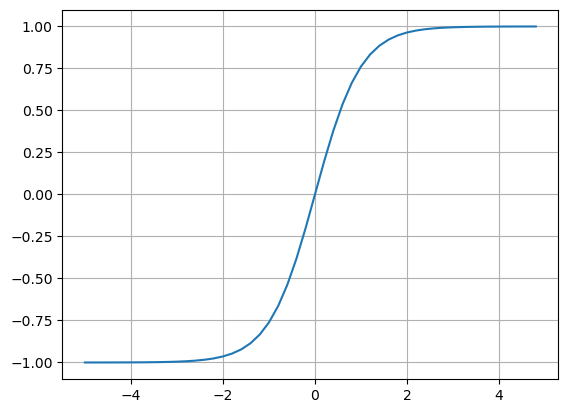

In [82]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();
plt.show()

In [83]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

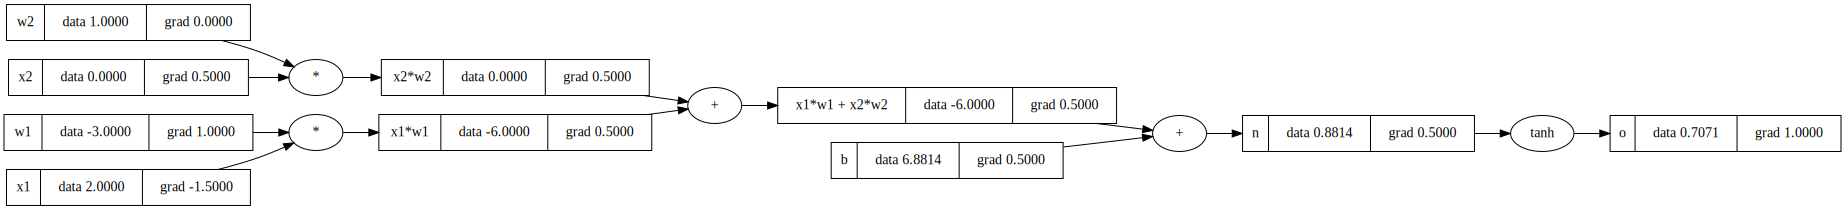

In [92]:
draw_dot(o)

In [85]:
o.grad = 1.0


In [86]:
o._backward()

In [87]:
n._backward()

In [88]:
b._backward()

In [89]:
x1w1x2w2._backward()

In [90]:
x2w2._backward()
x1w1._backward()

x1._backward()
x2._backward()

w1._backward()
w2._backward()

In [91]:
# o.grad = 1.0
# n.grad = 1 - o.data ** 2
# b.grad = 0.5

# x1w1x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data


do/do -> 1 
do/dn -> 1 -  tanh(n)**2